# Classification. Linear models and KNN

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.linear_model import SGDClassifier, LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder

## Part 1: Titanic survival prediction

### Dataset

Read the description here: https://www.kaggle.com/c/titanic/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/titanic/overview/evaluation.  


In [3]:
PATH = "./data/"

In [4]:
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')

In [5]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

In [6]:
## your code
data['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

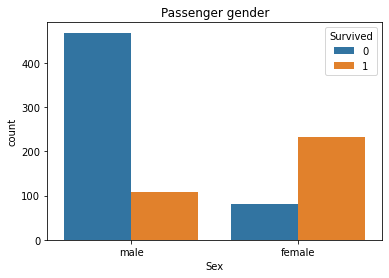

In [7]:
plt.title('Passenger gender')
sns.countplot(x='Sex', hue='Survived', data=data);

< your thoughts >  

Хорошо видно, что доля женщин среди выживших существеннно больше, чем среди погибших. Можно ожидать, что пол будет хорошим признаком.

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

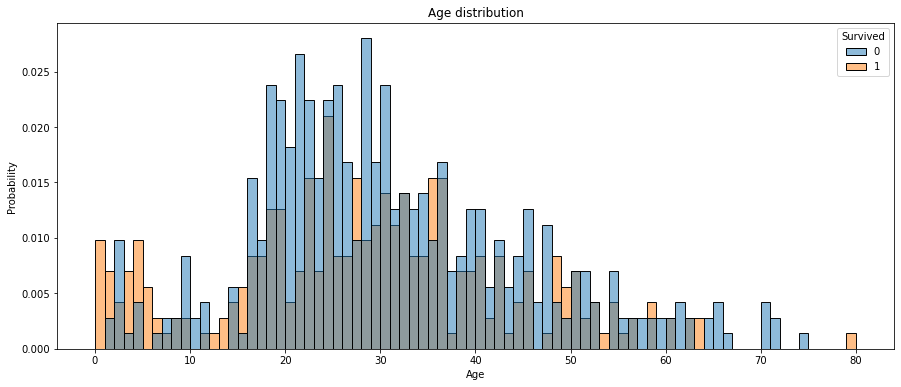

In [8]:
max_age = np.ceil(data['Age'].max()).astype('int')
age_bins = np.arange(max_age+1)
plt.figure(figsize=[15,6])
plt.title('Age distribution')
sns.histplot(data=data, x='Age', hue='Survived', stat='probability', bins=age_bins);
plt.show()

Средний возраст пассажиров

In [9]:
mean_age = data.groupby('Survived')['Age'].mean()
mean_age

Survived
0    30.626179
1    28.343690
Name: Age, dtype: float64

Медианный возраст пассажиров

In [10]:
median_age = data.groupby('Survived')['Age'].median()
median_age

Survived
0    28.0
1    28.0
Name: Age, dtype: float64

< your thoughts >

Распределения заметно отличаются для разных возрастных групп. Например, для детей в возрасте до 10 лет доля выживших больше, а в группе 20-30 лет доля погибших больше. По всей видимости, детей пытались спасти в первую очередь.

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

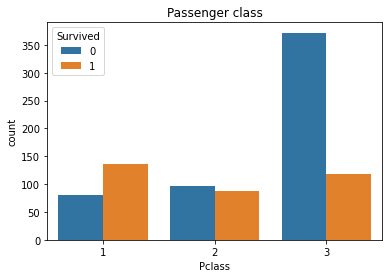

In [11]:
## your code
plt.title('Passenger class')
sns.countplot(x='Pclass', hue='Survived', data=data)
plt.show()

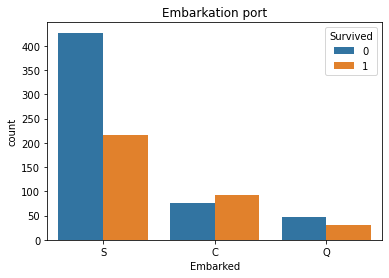

In [12]:
plt.title('Embarkation port')
sns.countplot(x='Embarked', hue='Survived', data=data)
plt.show()

< your thoughts >

Доля погибших заметно отличается для пассажиров разных классов.

Доля погибших больше в портах S и Q. Воэможно, это обьясняется тем, что большинство пассажиров 3 класса сели в этих портах, как видно на следующей диаграмме.

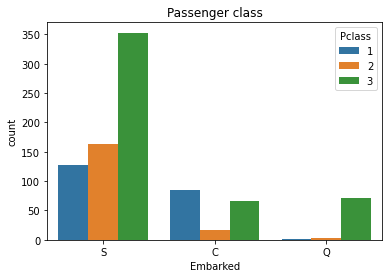

In [13]:
plt.title('Passenger class')
sns.countplot(x='Embarked', hue='Pclass', data=data)
plt.show()

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [14]:
## your code
data.isna().mean() * 100

Survived     0.000000
Pclass       0.000000
Name         0.000000
Sex          0.000000
Age         19.865320
SibSp        0.000000
Parch        0.000000
Ticket       0.000000
Fare         0.000000
Cabin       77.104377
Embarked     0.224467
dtype: float64

Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

< your thoughts >

Рассмотрим признак с отсутствующими значениями

**Embarked**

In [15]:
data['Embarked'].value_counts(dropna=False)

S      644
C      168
Q       77
NaN      2
Name: Embarked, dtype: int64

Всего для двух пассажиров (0,22% от общего числа) признак 'Embarked' неизвестен. Можно этих пассажиров исключить из рассмотрения. Или же заполнить пропущенные значения наиболее часто встречающимся значением признака Embarked.

**Cabin**

77% значений отсутствуют. Однако, само наличие указания номера каюты может быть хорошим признаком. Проверим это.

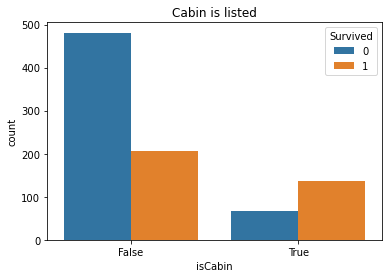

In [16]:
cabin = data[['Cabin', 'Survived']].copy()
cabin['isCabin'] = cabin['Cabin'].notna()
plt.title('Сabin is listed')
sns.countplot(x='isCabin', hue='Survived', data=cabin)
plt.show()

Диаграмма показывает, что если номер каюты указан, то пассажир скорее окажется среди выживших.

**Age**

Значения отсутствуют у ~20% пассажиров. Можно также исключить их из рассмотрения. Однако при этом мы теряем значительную долю примеров, в которой содержится ценная информация по другим признакам.
Другой способ состоит в том, чтобы заполнить пропущенные значения средним значением признака "Age".  
Еще один способ - заполнить средним возрастом, но не всех пассажиров, а средним возрастом похожей группы.
Остановимся пока на том, что заполним возраст средним значением. Так как медианный возраст у погибших и выживших одинаков, то пропущенные значения заполним медианным возрастом.

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [17]:
y = data['Survived']

In [18]:
## your code

Отбираем признаки.  
Категориальные признаки преобразуем в бинарные при помощи One Hot Encoding.

In [19]:
X = pd.get_dummies(data[['Pclass', 'Sex']], columns=['Pclass', 'Sex'])

Из диаграммы распределения возраста видно, что линейная зависимость между возрастом и тем, выжил ли пассажир отсутствует, т.е. применять напрямую возраст как признак линейной модели мы не можем. Однако для небольших диапазонов возрастов (например от 0 до 10 лет) связь отчетливая. Поделим весь диапазон возраста на несколько поддиапазанов и введем бинарные признаки принадлежности этим поддиапазонам.

In [20]:
X['Age'] = data['Age'].copy()
X['Age'].fillna(X['Age'].median(), inplace=True)
age_step = 15
age_bins = np.arange(0, max_age + age_step, age_step)
X['Age'] = pd.cut(X['Age'], bins=age_bins)
X = pd.get_dummies(X, columns=['Age'])

Добавим признак, указывающий, был ли указан номер каюты.

In [21]:
X['isCabin'] = data['Cabin'].notna()

In [22]:
X.head()

,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,"Age_(0, 15]","Age_(15, 30]","Age_(30, 45]","Age_(45, 60]","Age_(60, 75]","Age_(75, 90]",isCabin
PassengerId,,,,,,,,,,,,
1,0,0,1,0,1,0,1,0,0,0,0,False
2,1,0,0,1,0,0,0,1,0,0,0,True
3,0,0,1,1,0,0,1,0,0,0,0,False
4,1,0,0,1,0,0,0,1,0,0,0,True
5,0,0,1,0,1,0,0,1,0,0,0,False


Строим модели

In [23]:
lr = LogisticRegression(solver='liblinear', random_state=42)
knn = KNeighborsClassifier()

In [24]:
cross_val_score(lr, X, y, scoring='accuracy').mean()

0.7811185738497269

In [25]:
cross_val_score(knn, X, y, scoring='accuracy').mean()

0.7845709622748102

In [26]:
parameters = {'penalty':['l1', 'l2'], 'C':np.logspace(-4, 3, 8)}
clf = GridSearchCV(lr, parameters)
clf.fit(X, y)
cross_val_score(clf.best_estimator_, X, y, scoring='accuracy').mean()

0.7945828887075513

In [27]:
clf.best_params_

{'C': 0.1, 'penalty': 'l2'}

In [28]:
parameters = {'n_neighbors':np.arange(1,16)}
clf = GridSearchCV(knn, parameters)
clf.fit(X, y)
cross_val_score(clf.best_estimator_, X, y, scoring='accuracy').mean()

0.8114242671520934

In [29]:
clf.best_params_

{'n_neighbors': 10}

**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

In [30]:
## your code

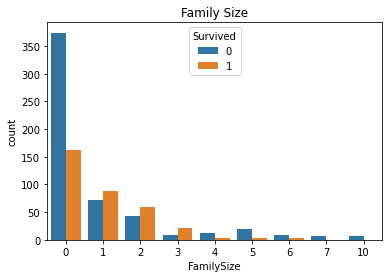

In [31]:
family = data[['Survived']].copy()
family['FamilySize'] = data['SibSp'] + data['Parch']
plt.title('Family Size')
sns.countplot(x='FamilySize', hue='Survived', data=family)
plt.show()

In [32]:
def prepare_features(data):
    X = pd.get_dummies(data[['Pclass', 'Sex']], columns=['Pclass', 'Sex'])
    
    X['Age'] = data['Age'].copy()
    X['Age'].fillna(X['Age'].median(), inplace=True)
    age_step = 15
    age_bins = np.arange(0, max_age + age_step, age_step)
    X['Age'] = pd.cut(X['Age'], bins=age_bins)
    X = pd.get_dummies(X, columns=['Age'])
    
    X['isCabin'] = data['Cabin'].notna()
    
    X['FamilySize'] = (data['SibSp'] + data['Parch'])
    X.loc[X['FamilySize'] >= 4, 'FamilySize'] = '4+'
    X = pd.get_dummies(X, columns=['FamilySize'])
    
    return X

In [33]:
X = prepare_features(data)

In [34]:
cross_val_score(lr, X, y, scoring='accuracy').mean()

0.805818843763731

In [35]:
cross_val_score(knn, X, y, scoring='accuracy').mean()

0.8092272926997678

#### Hyperparameter tuning

In [36]:
parameters = {'penalty':['l1', 'l2'], 'C':np.logspace(-4, 3, 8)}
lr_tuned = GridSearchCV(lr, parameters)
lr_tuned.fit(X, y)
cross_val_score(lr_tuned.best_estimator_, X, y, scoring='accuracy').mean()

0.805818843763731

In [37]:
lr_tuned.best_params_

{'C': 1.0, 'penalty': 'l1'}

In [38]:
parameters = {'n_neighbors':np.arange(1,16)}
knn_tuned = GridSearchCV(knn, parameters)
knn_tuned.fit(X, y)
cross_val_score(knn_tuned.best_estimator_, X, y, scoring='accuracy').mean()

0.8204193082669009

In [39]:
knn_tuned.best_params_

{'n_neighbors': 3}

Load the test set and make the predictions. Submit them to kaggle and see the results :)
Select the best model, load the test set and make the predictions. Submit them to kaggle.

**Note**. X points will depend on your kaggle leaderboard score.
$$ f(score) = 0.5, \ \ 0.76 \leq score < 0.78,$$
$$ f(score) = 1.0, \ \ 0.78 \leq score < 0.81,$$ 
$$ f(score) = 2.5, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.

In [40]:
## your code

In [41]:
test_data = pd.read_csv(os.path.join(PATH, 'titanic', 'test.csv')).set_index('PassengerId')
test_data.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [42]:
X_test = prepare_features(test_data)
X_test.head()

,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,"Age_(0, 15]","Age_(15, 30]","Age_(30, 45]","Age_(45, 60]","Age_(60, 75]","Age_(75, 90]",isCabin,FamilySize_0,FamilySize_1,FamilySize_2,FamilySize_3,FamilySize_4+
PassengerId,,,,,,,,,,,,,,,,,
892,0,0,1,0,1,0,0,1,0,0,0,False,1,0,0,0,0
893,0,0,1,1,0,0,0,0,1,0,0,False,0,1,0,0,0
894,0,1,0,0,1,0,0,0,0,1,0,False,1,0,0,0,0
895,0,0,1,0,1,0,1,0,0,0,0,False,1,0,0,0,0
896,0,0,1,1,0,0,1,0,0,0,0,False,0,0,1,0,0


In [43]:
lr_tuned.best_estimator_.fit(X, y)
lr_pred = lr_tuned.best_estimator_.predict(X_test)

In [44]:
output = pd.DataFrame({'PassengerId': test_data.index, 'Survived': lr_pred})
output.to_csv('lr_submission.csv', index=False)

Kaggle LB: 0.77511

In [45]:
knn_tuned.best_estimator_.fit(X, y)
knn_pred = knn_tuned.predict(X_test)

In [46]:
output = pd.DataFrame({'PassengerId': test_data.index, 'Survived': knn_pred})
output.to_csv('knn_submission.csv', index=False)

Kaggle LB: 0.75119

In [47]:
y_pred = lr_tuned.predict_proba(X_test) + knn_tuned.predict_proba(X_test)

In [48]:
y_pred = ((y_pred[:,0] / 2) < 0.5).astype(int)

In [49]:
output = pd.DataFrame({'PassengerId': test_data.index, 'Survived': y_pred})
output.to_csv('lr_knn_submission.csv', index=False)

## Part 2: Porto Seguro’s Safe Driver Prediction

Let's build a model that predicts the probability that a driver will initiate an auto insurance claim in the next year.
Read the detailed description and download the dataset https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/data. Put the data into *./data/porto/*.

In [50]:
insurance_data = pd.read_csv(os.path.join(PATH, 'porto', 'train.csv')).set_index('id')

In [51]:
insurance_data.head()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
id,,,,,,,,,,,,,,,,,,,,,
7,0,2,2,5,1,0,0,1,0,0,...,9,1,5,8,0,1,1,0,0,1
9,0,1,1,7,0,0,0,0,1,0,...,3,1,1,9,0,1,1,0,1,0
13,0,5,4,9,1,0,0,0,1,0,...,4,2,7,7,0,1,1,0,1,0
16,0,0,1,2,0,0,1,0,0,0,...,2,2,4,9,0,0,0,0,0,0
17,0,0,2,0,1,0,1,0,0,0,...,3,1,1,3,0,0,0,1,1,0


Let's skip EDA for now. We'll use SGDClassifier and build a simple baseline: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html.
Note that loss='log' gives logistic regression.

In [52]:
y = insurance_data['target']
X = insurance_data.drop(columns=['target'])

In [53]:
numeric_features = [column for column in X if not (column.endswith("cat") or column.endswith("bin"))]
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_features = [column for column in X if (column.endswith("cat") or column.endswith("bin"))]
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', SGDClassifier(loss='log', alpha=0.001, n_jobs=-1, random_state=14))])

In [54]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [55]:
clf = pipeline.fit(X_train, y_train)

We'll calculate the model accuracy:

In [56]:
accuracy_score(y_true=y_valid, y_pred=clf.predict(X_valid))

0.9631224658945812

Wow! Our model gets ~0.963 accuracy! But is it really good?...

Let's plot the confusion matrix and analyze the errors.

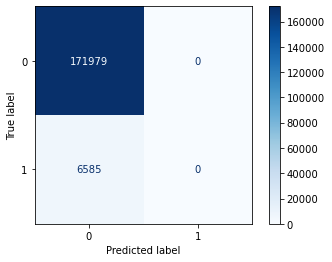

In [57]:
disp = plot_confusion_matrix(clf, X_valid, y_valid,
                             cmap=plt.cm.Blues,
                             normalize=None)

Well, it turns out that our model is completely useless. Let's calculate some basic statistics:

In [58]:
insurance_data.describe()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,...,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,1.900378,1.358943,4.423318,0.416794,0.405188,0.393742,0.257033,0.163921,0.185304,...,5.441382,1.441918,2.872288,7.539026,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,1.983789,0.664594,2.699902,0.493311,1.350642,0.488579,0.436998,0.370205,0.388544,...,2.332871,1.202963,1.694887,2.746652,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.000000,1.000000,2.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.000000,1.000000,3.000000,7.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,3.000000,2.000000,6.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,7.000000,2.000000,4.000000,9.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,7.000000,4.000000,11.000000,1.000000,6.000000,1.000000,1.000000,1.000000,1.000000,...,19.000000,10.000000,13.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


As you see, there are less than 4% of positive examples, so we have to deal with a highly imbalanced dataset.

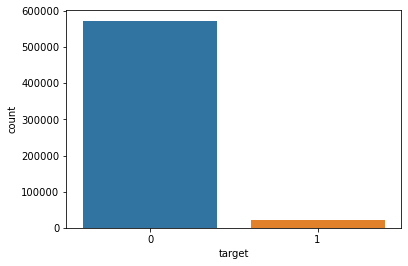

In [59]:
sns.countplot(x='target', data=insurance_data)
plt.show()

Accuracy is not informative here and the Normalized Gini Coefficient will be used instead: https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/overview/evaluation.

In [60]:
# Code for calculating Normalized gini coefficient
# https://www.kaggle.com/c/ClaimPredictionChallenge/discussion/703
def gini(actual, pred, cmpcol = 0, sortcol = 1):  
    assert(len(actual) == len(pred))  
    epsilon = 1e-7
    values = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)  
    values = values[np.lexsort((values[:, 2], -1 * values[:, 1]))]  
    total = values[:, 0].sum() 
    gini_sum = (values[:, 0].cumsum().sum() + epsilon) / (total + epsilon)  
  
    gini_sum -= (len(actual) + 1) / 2  
    return gini_sum / len(actual)  
  
def gini_normalized(a, p):  
    '''Function to calculate the normalized gini coefficient'''
    return gini(a, p) / gini(a, a)

**(1.5 points)** Prove that the **Normalized Gini Coefficient** is equivalent to **2 x AUC - 1** :

< your proof >

**(0.5 points)** By the way, what other metrics could you suggest for this problem?

< your thoughts >

Let's calculate the Normalized Gini Coefficient:

In [61]:
y_pred = clf.predict_proba(X_valid)[:, 1]

In [62]:
gini_normalized(y_valid, y_pred)

0.2558723581569817

**(0.5 points + Y bonus points)** Try different approaches: oversampling / undersampling, careful feature analysis and feature engineering, etc., to get a reasonable pipeline and improve the model quality. Use cross-validation for model evaluation.

Select the best model, load the test set and make the predictions. Submit them to kaggle.
Y bonus points will be calculated as $\frac{round(200 * \max(score - 0.253, 0))}{2}$, where *score* is your kaggle leaderboard score.

Note: do not use any classification models which have not been covered in the lessons yet.

In [63]:
## your code